### I. Commentaire de l'article "The Cointegration Alpha: Enhanced Index Tracking and Long-Short Equity Market Neutral Strategies"

Cet article propose différentes applications de stratégies d'investissement basées sur la cointégration, on note : 

- une stratégie classique de suivi d'indices;
- une stratégie d'actions long-short market neutral;
- une combinaison des deux approches précédentes.

L'idée de la première stratégie est de reproduire les rendements et la volatilité d'un indice de référence spécifique (exemple du CAC40), c'est-à-dire un portefeuille ayant de propriétés similaires à celui de l'indice en termes de rendements, volatilité et corrélation; tandis que les deux stratégies suivantes visent à minimiser la volatilité et générer des rendements stables quelles que soient les conditions de marché.

L'avantage de se baser sur la cointégration pour l'optimisation de portefeuille est qu'elle permet d'utiliser toutes les informations comprises dans les prix et de construire des poids sur le comportement long terme des actions.

One of the advantages of estimating the portfolio weights based on cointegration coefficients is their
enhanced stability. Being constructed on a rather long history of prices, they tend to ignore short-term
movements in stock prices, such as bubbles or just noise, and focus on the long-run behaviour of the
prices. 

The main point of our analysis was to show that, when applied to constructing trading strategies, the
cointegration technique produces encouraging results. Its key characteristics, i.e. mean reverting
tracking error, enhanced weights stability and better use of the information contained in stock prices,
allow a flexible design of various trading strategies, from index tracking to long-short market neutral.

## II. Expériences numériques transposées au marché français.

### 0. Data 

On pré-processe ici les données du CAC40 de 2001 à nos jours. Pour certaines valeurs, les données sont manquantes à partir d'un certain rang, on les complète naïvement par la dernière valeur présente dans cette colonne.

In [1]:
import pandas as pd
import numpy as np
from utils_long_short import calculer_rendement_iteratif, perform_regression, rebalance_and_evaluate, calculate_annual_global_metrics
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats

In [2]:
file_path = '../data/CAC.xlsx'
sheet_name_weights = 'Worksheet'
sheet_name_data = 'Data'

df_weights = pd.read_excel(file_path, sheet_name=sheet_name_weights, index_col=0)
dict_weights_CAC = df_weights['Poids'].to_dict()

df_data = pd.read_excel(file_path, sheet_name=sheet_name_data, index_col=0)
df_data = df_data.fillna(method='ffill')

/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_23781/1987031244.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_data = df_data.fillna(method='ffill')


In [3]:
dict_weights_CAC

{'AI FP Equity': 0.0534,
 'AIR FP Equity': 0.0476,
 'ALO FP Equity': 0.0022,
 'MT NA Equity': 0.0077,
 'CS FP Equity': 0.0327,
 'BNP FP Equity': 0.0426,
 'EN FP Equity': 0.0038,
 'CAP FP Equity': 0.0182,
 'CA FP Equity': 0.0055,
 'SGO FP Equity': 0.0178,
 'ML FP Equity': 0.0133,
 'ACA FP Equity': 0.0079,
 'BN FP Equity': 0.0217,
 'DSY FP Equity': 0.0173,
 'EDEN FP Equity': 0.0078,
 'ENGI FP Equity': 0.017,
 'EL FP Equity': 0.0332,
 'ERF FP Equity': 0.0043,
 'RMS FP Equity': 0.0352,
 'KER FP Equity': 0.0173,
 'OR FP Equity': 0.0619,
 'LR FP Equity': 0.0146,
 'MC FP Equity': 0.1064,
 'ORA FP Equity': 0.0111,
 'RI FP Equity': 0.019,
 'PUB FP Equity': 0.0112,
 'RNO FP Equity': 0.0045,
 'SAF FP Equity': 0.0335,
 'SAN FP Equity': 0.0585,
 'SU FP Equity': 0.0601,
 'GLE FP Equity': 0.0104,
 'STLAP FP Equity': 0.029,
 'STMPA FP Equity': 0.0168,
 'TEP FP Equity': 0.0046,
 'HO FP Equity': 0.0081,
 'TTE FP Equity': 0.09,
 'URW FP Equity': 0.0046,
 'VIE FP Equity': 0.0101,
 'DG FP Equity': 0.0351,


In [4]:
df_data.columns

Index(['CAC Index', 'OR FP Equity', 'DG FP Equity', 'STLAP FP Equity',
       'TTE FP Equity', 'DSY FP Equity', 'AI FP Equity', 'ERF FP Equity',
       'CS FP Equity', 'BNP FP Equity', 'BN FP Equity', 'SGO FP Equity',
       'MC FP Equity', 'EDEN FP Equity', 'ML FP Equity', 'KER FP Equity',
       'PUB FP Equity', 'RNO FP Equity', 'SAF FP Equity', 'HO FP Equity',
       'TEP FP Equity', 'RMS FP Equity', 'ENGI FP Equity', 'ORA FP Equity',
       'MT NA Equity', 'EN FP Equity', 'ALO FP Equity', 'VIE FP Equity',
       'SAN FP Equity', 'GLE FP Equity', 'SU FP Equity', 'AIR FP Equity',
       'URW FP Equity', 'LR FP Equity', 'ACA FP Equity', 'RI FP Equity',
       'STMPA FP Equity'],
      dtype='object')

In [76]:
df_data['SAF FP Equity']

Date
2001-01-02     24.6514
2001-01-03     23.3143
2001-01-04     24.1886
2001-01-05     23.6229
2001-01-08     23.6743
                ...   
2024-02-22    191.4400
2024-02-23    193.0200
2024-02-26    193.6600
2024-02-27    192.3200
2024-02-28    193.2200
Name: SAF FP Equity, Length: 5929, dtype: float64

# Long short Market neutral strategy 

On ajoute au benchmark en rendement supplémentaire de x% distrbué uniformément sur les jours. On va prendre x valant 5%, 10% et 15%. On le retire et on l'ajoute pour contruire un 'index_plus' et un 'index_minus'. 

### Création d'un index_plus et d'un index_minus

La fonction calculer rendement iteratif permet de d'ajouter un pourcentage au rendement du cac40. 

In [3]:
data = df_data[['CAC Index','ACA FP Equity','OR FP Equity', 'DG FP Equity', 'STLAP FP Equity',
       'TTE FP Equity','STMPA FP Equity','ML FP Equity','ALO FP Equity','CS FP Equity','SAF FP Equity']] #on choisit de travailler sur uniquement quelques valeurs  
#'CAC Index','ACA FP Equity','OR FP Equity', 'DG FP Equity', 'STLAP FP Equity',
 #      'TTE FP Equity'

In [4]:
df_plus_5_5y = calculer_rendement_iteratif(data, '2008-01-03', 5) #dataframe, date_depart, augmentation par an en pourcentage
df_min_5_5y = calculer_rendement_iteratif(data, '2008-01-03', -5)# 5%


df_plus_10_5y = calculer_rendement_iteratif(data, '2008-01-03', 10) #dataframe, date_depart, augmentation par an en pourcentage
df_min_10_5y = calculer_rendement_iteratif(data, '2008-01-03', -10) #10% 


df_plus_15_5y = calculer_rendement_iteratif(data, '2008-01-03', 15) #dataframe, date_depart, augmentation par an en pourcentage
df_min_15_5y = calculer_rendement_iteratif(data, '2008-01-03', -15) #15% d'augmentation ici 


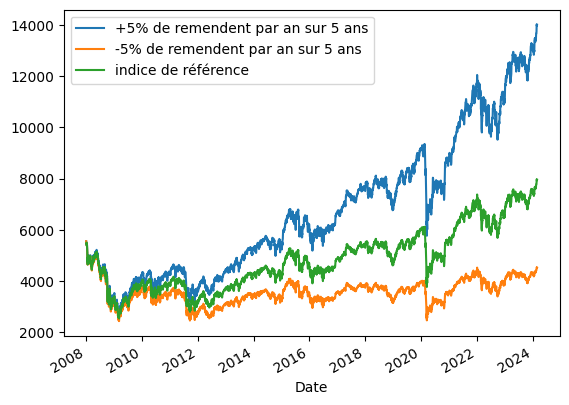

In [5]:
df_plus_5_5y["CAC Index Ajusté"].plot(label="+5% de remendent par an sur 5 ans")
df_min_5_5y["CAC Index Ajusté"].plot(label="-5% de remendent par an sur 5 ans")
df_data.loc["2008-01-05 ":]["CAC Index"].plot(label="indice de référence")
plt.legend()
plt.show() 

La nouvelle cointegration décrite dans l'article s'écrit de la manière suivante:

In [14]:
params_plus_intercept, params_plus, residuals_plus = perform_regression(df_plus_15_5y)
params_moins_intercept, params_moins, residuals_moins = perform_regression(df_min_15_5y)
print('les paramètres fit sont pour l\'index_plus: \n',params_plus)

print('les paramètres fit sont pour l\'index_moins: \n',params_moins)



les paramètres fit sont pour l'index_plus: 
 ACA FP Equity      0.015460
OR FP Equity       0.694168
DG FP Equity       0.320110
STLAP FP Equity    1.115386
TTE FP Equity      0.193951
STMPA FP Equity    0.164210
ML FP Equity      -0.090386
ALO FP Equity     -0.107308
CS FP Equity       0.051497
SAF FP Equity      0.061183
dtype: float64
les paramètres fit sont pour l'index_moins: 
 ACA FP Equity     -0.143938
OR FP Equity      -0.131720
DG FP Equity      -0.326795
STLAP FP Equity    2.115149
TTE FP Equity      0.362494
STMPA FP Equity   -0.049583
ML FP Equity       0.270297
ALO FP Equity      0.212982
CS FP Equity       0.460918
SAF FP Equity     -0.244641
dtype: float64


### Backtest de la stratégie. 
On va ici ré-éstimer tous les 10 jours nos poids sur la période [date départ, date précédente+10]. On va à chaque fois que l'on rebalance nos poids s'assurer que le test ADF est correct, i.e. que la cointégration fonctionne proprement, et nous allons plotter ce graphique. On va aussi calculer le prix que l'on obtient en soustrayant les couts. Cela nous permettra d'avoir un rendement en temps réel de notre stratégie, vs un rendement de l'indice. Le fait d'avoir le prix en continu devrait nous permettre aussi d'avoir la volatilité, la possibilité de calculer la skewness et la kurtosis, ainsi que les sharpe ratio. 

In [7]:
#le backtest de nos différentes stratégies 
adf_critic_value_5, adf_stats_list_5,replication_max_5,replication_min_5 = rebalance_and_evaluate(df_plus_5_5y,df_min_5_5y,'2008-01-03',1)
adf_critic_value_10, adf_stats_list_10,replication_max_10,replication_min_10 = rebalance_and_evaluate(df_plus_10_5y,df_min_10_5y,'2008-01-03',1)
adf_critic_value_15, adf_stats_list_15,replication_max_15,replication_min_15 = rebalance_and_evaluate(df_plus_15_5y,df_min_15_5y,'2008-01-03',1)


/Users/adriencortes/Documents/3- Cours /7- EK/allocation actifs/Allocation-actifs/src/utils_long_short.py:138: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  portfolio = pd.concat([portfolio, portfolio_price_plus-portfolio_price_minus])
/Users/adriencortes/Documents/3- Cours /7- EK/allocation actifs/Allocation-actifs/src/utils_long_short.py:139: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  replication_max = pd.concat([replication_max, portfolio_price_plus])
/Users/adriencortes/Documents/3- Cours /7- EK/allocation actifs/Allocation-actifs/src/utils_long_s

On peut plot le test ADF pour vérifier de la cohérence de nos résultats. 

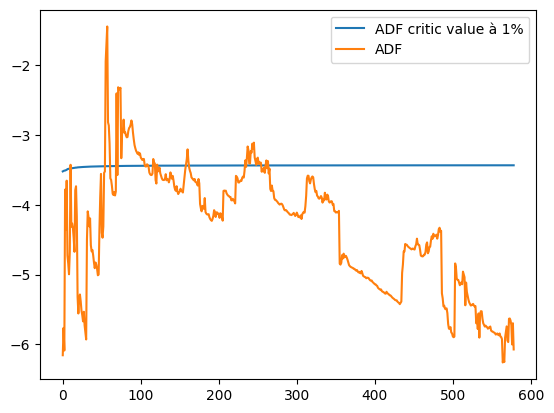

In [8]:
plt.plot(adf_critic_value_15[10:],label="ADF critic value à 1%")
plt.plot(adf_stats_list_15[10:],label = "ADF")
plt.legend()

On peut vérifier ci-dessous que l'on réplique bien les indices de hausses et de baisse. 

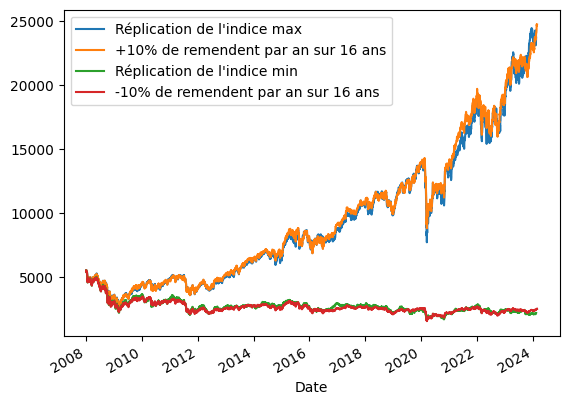

In [15]:
plt.plot(replication_max_10,label="Réplication de l'indice max")
df_plus_10_5y["CAC Index Ajusté"].plot(label="+10% de remendent par an sur 16 ans")

plt.plot(replication_min_10,label="Réplication de l'indice min")
df_min_10_5y["CAC Index Ajusté"].plot(label="-10% de remendent par an sur 16 ans")

plt.legend()
plt.show() 

On a donc mis en place une stratégie qui permet de répliquer les indices longs et courts. Il suffit maintenant de regarder la différence des rendements annuels des deux stratégies. Cela nous donnera le rendement de notre stratégie finale, nous allons pouvoir regarder ces rendements en fonction du temps, le sharpe ratio, la skewness et la kurtosis. 

In [51]:
replication_max_5.resample('M').last().pct_change()

/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_23781/3119395275.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  replication_max_5.resample('M').last().pct_change()


,0
2008-01-31,NaN
2008-02-29,-0.004916
2008-03-31,-0.019896
2008-04-30,0.067760
2008-05-31,0.002279
...,...
2023-10-31,-0.008917
2023-11-30,0.060064
2023-12-31,0.029011
2024-01-31,-0.011273


/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_23781/3799661033.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot((replication_max_5.resample('M').last().pct_change() - replication_min_5.resample('M').last().pct_change()),label="rendements mensuels, strat 5%")
/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_23781/3799661033.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot((replication_max_10.resample('M').last().pct_change() - replication_min_10.resample('M').last().pct_change()),label="rendements mensuels, strat 10%")
/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_23781/3799661033.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot((replication_max_15.resample('M').last().pct_change() - replication_min_15.resample('M').last().pct_change()),label="rendements

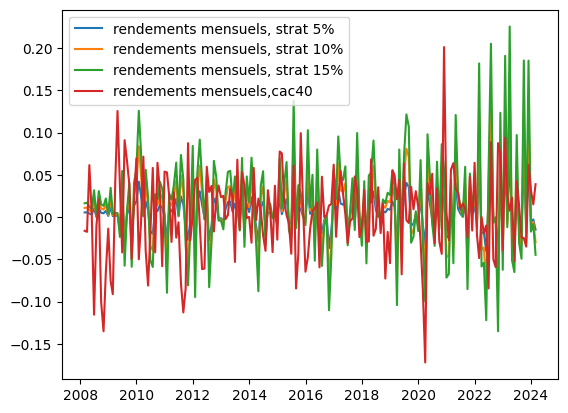

In [61]:
plt.plot((replication_max_5.resample('M').last().pct_change() - replication_min_5.resample('M').last().pct_change()),label="rendements mensuels, strat 5%")
plt.plot((replication_max_10.resample('M').last().pct_change() - replication_min_10.resample('M').last().pct_change()),label="rendements mensuels, strat 10%")
plt.plot((replication_max_15.resample('M').last().pct_change() - replication_min_15.resample('M').last().pct_change()),label="rendements mensuels, strat 15%")
plt.plot((df_data["CAC Index"].loc['2008-01-01':].resample('M').last().pct_change()),label="rendements mensuels,cac40")
plt.legend()

plt.show()

In [64]:
rendements_mensuels_5 = replication_max_5.resample('M').last().pct_change() - replication_min_5.resample('M').last().pct_change()
rendements_mensuels_10 = replication_max_10.resample('M').last().pct_change() - replication_min_10.resample('M').last().pct_change()
rendements_mensuels_10 = replication_max_15.resample('M').last().pct_change() - replication_min_15.resample('M').last().pct_change()
rendement_cac40 = df_data["CAC Index"].loc['2008-01-01':].resample('M').last().pct_change()

/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_23781/1922390448.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rendements_mensuels_5 = replication_max_5.resample('M').last().pct_change() - replication_min_5.resample('M').last().pct_change()
/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_23781/1922390448.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rendements_mensuels_10 = replication_max_10.resample('M').last().pct_change() - replication_min_10.resample('M').last().pct_change()
/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_23781/1922390448.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rendements_mensuels_10 = replication_max_15.resample('M').last().pct_change() - replication_min_15.resample('M').last().pct_change()
/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipyker

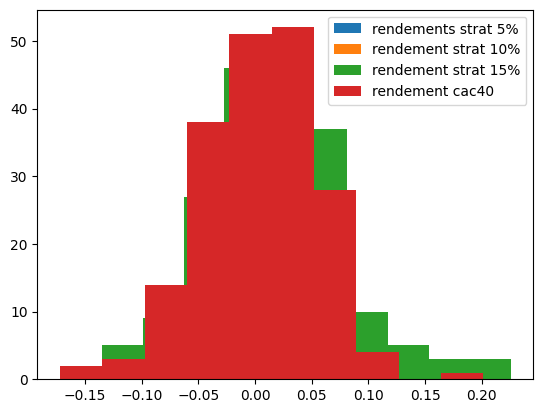

In [65]:
plt.hist(rendements_mensuels_5,label="rendements strat 5%")
plt.hist(rendements_mensuels_10,label="rendement strat 10%")
plt.hist(rendements_mensuels_10,label="rendement strat 15%")
plt.hist(rendement_cac40,label="rendement cac40")
plt.legend()

In [68]:


ratio_sharpe = rendements_mensuels_10.mean()/np.sqrt(rendements_mensuels_10.var()) #le ratio de sharpe final
skew =rendements_mensuels_10.skew()
kurtosis = rendements_mensuels_10.kurtosis()

print("La skew est :",skew," le ratio de sharpe : ",ratio_sharpe," et le kurtosis",kurtosis ) #pour calculer le ratio de sharpe, on a fait l'hyp que le taux sans risque est nul
#on n'a pas repris un taux repo pour le ratio de sharpe. 

La skew est : 0    0.474758
dtype: float64  le ratio de sharpe :  0    0.297727
dtype: float64  et le kurtosis 0    1.213759
dtype: float64


In [17]:
annual_metrics_5 = calculate_annual_global_metrics(replication_max_5, replication_min_5)
annual_metrics_10 = calculate_annual_global_metrics(replication_max_10, replication_min_10)
annual_metrics_15 = calculate_annual_global_metrics(replication_max_15, replication_min_15) #on calcul les métriques les plus importantes 
annual_metrics_10

,Annual Global Return,Daily mean Return,Daily Variance of Global Return
2008,0.120879,0.000418,0.000018
2009,0.056420,0.000216,0.000042
2010,0.211068,0.000708,0.000062
2011,0.105164,0.000388,0.000069
2012,0.092250,0.000348,0.000070
2013,0.206127,0.000685,0.000031
2014,0.037723,0.000152,0.000037
2015,0.234264,0.000778,0.000058
2016,0.018186,0.000095,0.000063
2017,0.239190,0.000792,0.000057


Pour la stratégie ou je rajoute 5% à l'indice : 

In [71]:


ratio_sharpe = annual_metrics_5["Annual Global Return"].mean()/np.sqrt(annual_metrics_5["Annual Global Return"].var()) #le ratio de sharpe final
skew = annual_metrics_5["Annual Global Return"].skew()
kurtosis = annual_metrics_5["Annual Global Return"].kurtosis()

print("La skew est :",skew," le ratio de sharpe : ",ratio_sharpe," et le kurtosis",kurtosis ) #pour calculer le ratio de sharpe, on a fait l'hyp que le taux sans risque est nul
#on n'a pas repris un taux repo pour le ratio de sharpe. 

La skew est : 1.0641222949270652  le ratio de sharpe :  1.3058427530262495  et le kurtosis 2.5088465890062497


Pour le cas où l'on a ajouté 10% au rendement 

In [70]:


ratio_sharpe = annual_metrics_10["Annual Global Return"].mean()/np.sqrt(annual_metrics_10["Annual Global Return"].var()) #le ratio de sharpe final
skew = annual_metrics_10["Annual Global Return"].skew()
kurtosis = annual_metrics_10["Annual Global Return"].kurtosis()

print("La skew est :",skew," le ratio de sharpe : ",ratio_sharpe," et le kurtosis",kurtosis ) #pour calculer le ratio de sharpe, on a fait l'hyp que le taux sans risque est nul
#on n'a pas repris un taux repo pour le ratio de sharpe. 

La skew est : 1.2438005157819219  le ratio de sharpe :  1.2064137971140354  et le kurtosis 2.8067436607819265


Pour un code qui ajoute 15% à la performance 

In [69]:


ratio_sharpe = annual_metrics_15["Annual Global Return"].mean()/np.sqrt(annual_metrics_15["Annual Global Return"].var()) #le ratio de sharpe final
skew = annual_metrics_15["Annual Global Return"].skew()
kurtosis = annual_metrics_15["Annual Global Return"].kurtosis()

print("La skew est :",skew," le ratio de sharpe : ",ratio_sharpe," et le kurtosis",kurtosis ) #pour calculer le ratio de sharpe, on a fait l'hyp que le taux sans risque est nul
#on n'a pas repris un taux repo pour le ratio de sharpe. 

La skew est : 1.3696331143487288  le ratio de sharpe :  1.110452583079979  et le kurtosis 3.0049645645048453


Il peut être intéressant aussi de regarder la corrélation des rendements avec les rendements de l'indice. 

Les rendements sont peu corrélés avec ceux de l'indice. Seulement de 14%. 

In [21]:
daily_return_indice = df_data["CAC Index"].loc['2008-01-01':].pct_change().dropna()
daily_return_indice = daily_return_indice.groupby(daily_return_indice.index.year)
daily_return_indice.apply(lambda x: (1 + x).prod() - 1)

Date
2008   -0.420223
2009    0.223234
2010   -0.033419
2011   -0.169516
2012    0.152307
2013    0.179859
2014   -0.005400
2015    0.085264
2016    0.048576
2017    0.092600
2018   -0.109527
2019    0.263676
2020   -0.071369
2021    0.288507
2022   -0.094963
2023    0.165193
2024    0.054514
Name: CAC Index, dtype: float64

In [72]:
print( "Pour la matrice 5% :", np.corrcoef(annual_metrics_5["Annual Global Return"],daily_return_indice.apply(lambda x: (1 + x).prod() - 1)),"\n") #finalement les rendements annuels ne sont pas corrélés 
print( "Pour la matrice 10% :", np.corrcoef(annual_metrics_10["Annual Global Return"],daily_return_indice.apply(lambda x: (1 + x).prod() - 1)),"\n")
print( "Pour la matrice 15% :", np.corrcoef(annual_metrics_15["Annual Global Return"],daily_return_indice.apply(lambda x: (1 + x).prod() - 1)),"\n")

Pour la matrice 5% : [[1.         0.14578492]
 [0.14578492 1.        ]] 

Pour la matrice 10% : [[1.         0.15600335]
 [0.15600335 1.        ]] 

Pour la matrice 15% : [[1.         0.16436564]
 [0.16436564 1.        ]] 

